# Computational Methods in Simulation (CMIS) Week 7
This notebook is intended to support your learning process. It contains exercises that help you to understand the material. 

This week is based on Slides 21 - follow the detailed instructions in order to build your own simulator:

* Hints: You might want to re-visit your FEM and FVM code pieces and reuse subparts of them for this larger project. The meshing week might prove useful for creating your own test cases to play with.

* Derive theory of how to create your own FVM simulator for simulating dynamic hyperelastic materials using a Saint-Vernant-Kirchoff model and a semi-implicit time-stepping scheme.
* Design experiments for verification and validation of your own simulator
* Present results of your experiments and discuss your findings
* If time is available try and extend the simulator to use adaptive or higher order time-stepping
* If time is available try and extend the simulator to use other types of material models
* If time is available try and extend the simulator to have dynamic boundary conditions to model "contact" when objects move around.

## Important Remark

* Do not be too agressive in terms of too large time-step size, too stiff materials and too large gravity. The semi-explicit nature of this overall method is quite sensitive, so use soft materials, almost no gravity and very small time-steps is recommended for prototyping and initial implementation. Once, it has been verified that code works, one can crank up values as close to reality as possible.

## Detailed Expected Learning Objectives of this Week

* Combine and show all skills learned through out the course.
* Design interesting and relevant experiments for verification and validation.
* Successfully create and discuss experimental results.
* Demonstrate ability to scientific discuss and reflect on the simulator.

In [1]:
%matplotlib widget

In [2]:
import igl
import meshplot as mp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Handling Mesh Geometry Information
In this week we may be able to resue material from previous weeks. In particular the beam mesh generation function will be useful to us.

However, we make one important slight change to this mesh generation function to avoid ear-triangles when we ask it to generate an even number of horitonal and vertical nodes.

Ear triangles form a degenerate control volume and we do not like them for this reason. The most easy fix is to make sure we never generate ear-triangle in the first place.

In [3]:
def vec2(x,y):
    return np.array([x, y],dtype=np.float64)


def hat(p):
    return vec2(-p[1], p[0])


def compute_triangle_areas(V,T):
    E = len(T) # Total number of triangles in the mesh
    A = np.zeros((E,),dtype=np.float64)
    for e in range(E):
        # Get triangle indices
        i = T[e,0]
        j = T[e,1]
        k = T[e,2]
        # Get triangle coordinates
        xi = V[i,0]
        xj = V[j,0]
        xk = V[k,0]
        yi = V[i,1]
        yj = V[j,1]
        yk = V[k,1]    
        
        dx1 = xk - xj
        dy1 = yk - yj
        dx2 = xi - xj
        dy2 = yi - yj

        A[e] =  (dx1*dy2 - dx2*dy1 ) / 2.0
    return A


def make_beam_mesh(width, height, shape):
    x0 = -width/2.0
    y0 = -height/2.0
    I  = shape[0]
    J  = shape[1]
    dx = width/float(I)
    dy = height/float(J)
    V = np.zeros(((I+1)*(J+1),2),dtype=np.float64)
    for j in range(J+1):
        for i in range(I+1):
            k = i + j*(I+1)
            V[k,0] = x0 + i*dx
            V[k,1] = y0 + j*dy
    T = np.zeros((2*I*J,3),dtype=np.int32)
    for j in range(J):
        for i in range(I):
            k00 = (i  ) + (j  )*(I+1)
            k01 = (i+1) + (j  )*(I+1)
            k10 = (i  ) + (j+1)*(I+1)
            k11 = (i+1) + (j+1)*(I+1)
            e = 2*(i + j*I)
            if (i+j+1)%2:
                T[e,  :] = (k00,k01,k11)
                T[e+1,:] = (k00,k11,k10)
            else:
                T[e,  :] = (k10,k00,k01)
                T[e+1,:] = (k10,k01,k11)                    
    return V, T

Later we will need to build a data structure for our control volumes. To create the control volumes we need to be able to query the mesh about connectivity information and geometric information as well. That is things like all triangles that share the same vertex or the outward unit normals of a triangle and so on.

To make this easy we provide a MeshInfo class that encapsulates simple libigl functionality into a more human readiable interface.

It is a great help to know how to "jump" around neighbors in a mesh data structure. We encourage therefore that students spend a bit of time getting into how this works so they can extend and customize their data structures as they need to with little effort.

In [4]:
class MeshInfo:
    
    def __init__(self, V, T):        
        self.A = compute_triangle_areas(V,T)
        if np.any(np.where(self.A<=0)):
            raise ValueError('Triangle with negative orientation exist.')
        bc = igl.barycenter(V,T)
        E = igl.edges(T)
        TT, _ = igl.triangle_triangle_adjacency(T)
        VT, NI = igl.vertex_triangle_adjacency(T, len(V))
        VV = igl.adjacency_list(T)
        self.V = V    # Vertices
        self.T = T    # Triangles
        self.E = E    # Edges
        self.TT = TT  # Triangle neighbors of triangles
        self.VT = VT  # Triangle neighbors of vertices
        self.NI = NI  # Vertex neighbor indices used to extract triangle neighbors of vertices
        self.VV = VV  # Vertex neighbors of vertices
        self.bc = bc  # Barycenters of triangles        
        boundary_mask = np.zeros(len(V),dtype=np.int32)
        boundary_mask[igl.boundary_loop(T)] = 1
        self.boundary_vertex = boundary_mask # Boundary mask of vertices, if 1 then a vertex is boundary otherwise it is interior.
        
        ### THIS IMPLEMENTATION OF BOUNDARY CONDITIONS IS NOT VERY GENERAL ###
        left_boundary_mask = np.zeros(len(V), dtype=np.int32)
        right_boundary_mask = np.zeros(len(V), dtype=np.int32)
        top_boundary_mask = np.zeros(len(V), dtype=np.int32)
        bottom_boundary_mask = np.zeros(len(V), dtype=np.int32)
        
        left_boundary_mask[np.where(V[:,0]==V[:,0].min())[0].tolist()] = 1
        right_boundary_mask[np.where(V[:,0]==V[:,0].max())[0].tolist()] = 1
        top_boundary_mask[np.where(V[:,1]==V[:,1].max())[0].tolist()] = 1
        bottom_boundary_mask[np.where(V[:,1]==V[:,1].min())[0].tolist()] = 1
        
        self.traction_boundary_vertex = right_boundary_mask
        self.free_boundary_vertex = [max(top_boundary_mask[i], bottom_boundary_mask[i]) for i in range(len(V))]
        self.static_boundary_vertex = left_boundary_mask
        #######################################################################
        
    def get_triangles_of_vertex(self, i):
        start = self.NI[i]
        end = self.NI[i+1]
        return self.VT[ start:end]

    def get_triangles_of_triangle(self, t):
        return self.TT[t]
    
    def get_triangle_center(self,t):
        return self.bc[t]
    
    def get_vertices_of_vertex(self, i):
        return self.VV[i]
    
    def get_triangle_area(self, t):
        return self.A[t]
    
    def get_edge_vector_of_triangle(self, t, e):
        i = self.T[t,e]
        j = self.T[t,(e+1)%3]
        vi = self.V[i,:].flatten()
        vj = self.V[j,:].flatten()
        u = (vj-vi).flatten()
        return u, (vi+vj)/2

    def get_outward_normal_of_triangle(self, t, e):
        u, m = self.get_edge_vector_of_triangle(t,e)
        n = -hat(u)/np.linalg.norm(u)
        return n, m
    
    def get_triangle_triangle_segment(self, t, e):
        n = self.TT[t,e]
        if n>0:
            ct = self.bc[t].flatten()
            cn = self.bc[n].flatten()
            return cn-ct, (cn+ct)/2
        return None, None    

    def get_opposing_triangle(self, t, v):
        e = (v+1)%3
        return self.TT[t,e]
    
    def is_boundary_vertex(self,v):
        if self.boundary_vertex[v]==1:
            return True
        return False
    
    def is_traction_vertex(self, v):
        if self.traction_boundary_vertex[v]==1:
            return True
        return False
    
    def is_static_vertex(self, v):
        if self.static_boundary_vertex[v]==1:
            return True
        return False
    
    def is_free_vertex(self, v):
        if self.free_boundary_vertex[v]==1:
            return True
        return False

In [5]:
[0, 1, 2, 3]

[0, 1, 2, 3]

We will now run a simple test example of the mesh generation and mesh info data structure to verify that things are working as expected. 

In particular we want to make sure we have no ears in the mesh, and all neighborhood information are in order too.

vertex  0  has triangle neighbors  [0 1]
vertex  1  has triangle neighbors  [0 2]
vertex  2  has triangle neighbors  [2 3]
vertex  3  has triangle neighbors  [1 4]
vertex  4  has triangle neighbors  [0 1 2 3 4 5 6 7]
vertex  5  has triangle neighbors  [3 6]
vertex  6  has triangle neighbors  [4 5]
vertex  7  has triangle neighbors  [5 7]
vertex  8  has triangle neighbors  [6 7]
Triangle  0  has triangle neighbors  [-1  2  1]
Triangle  1  has triangle neighbors  [ 0  4 -1]
Triangle  2  has triangle neighbors  [ 0 -1  3]
Triangle  3  has triangle neighbors  [ 2 -1  6]
Triangle  4  has triangle neighbors  [-1  1  5]
Triangle  5  has triangle neighbors  [ 4  7 -1]
Triangle  6  has triangle neighbors  [ 3 -1  7]
Triangle  7  has triangle neighbors  [ 6 -1  5]
vertex  0  has vertex neighbors  [1, 3, 4]
vertex  1  has vertex neighbors  [0, 2, 4]
vertex  2  has vertex neighbors  [1, 4, 5]
vertex  3  has vertex neighbors  [0, 4, 6]
vertex  4  has vertex neighbors  [0, 1, 2, 3, 5, 6, 7, 8]
verte

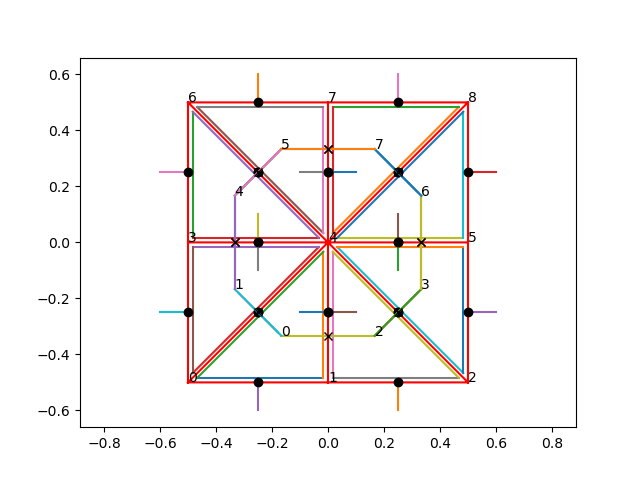

In [6]:
V, T = make_beam_mesh(1.0,1.0,(2,2))

info = MeshInfo(V,T)

fig = plt.figure()
plt.triplot(info.V[:,0],info.V[:,1],info.T,color='r')
for v in range(len(V)):
    print('vertex ',v , ' has triangle neighbors ',info.get_triangles_of_vertex(v))
    plt.text(info.V[v,0],info.V[v,1], str(v))
for t in range(len(T)):
    print('Triangle ',t , ' has triangle neighbors ',info.get_triangles_of_triangle(t))
    c = info.get_triangle_center(t)
    plt.text(c[0],c[1], str(t))
for v in range(len(V)):
    print('vertex ',v , ' has vertex neighbors ',info.get_vertices_of_vertex(v))
for t in range(len(T)):
    c = info.get_triangle_center(t)
    for e in range(3):
        u, m = info.get_edge_vector_of_triangle(t,e)
        v = m - 0.5*u
        w = m + 0.5*u
        m = (m-c)*0.9 + c
        v = (v-c)*0.9 + c
        w = (w-c)*0.9 + c
        plt.plot([v[0], w[0]], [v[1], w[1]] )
for t in range(len(T)):
    for e in range(3):
        n, m = info.get_outward_normal_of_triangle(t,e)
        plt.plot([m[0], 0.1*n[0]+m[0]], [m[1], 0.1*n[1]+m[1]] )
        plt.plot(m[0], m[1],'ko')
for t in range(len(T)):
    for e in range(3):
        u, m = info.get_triangle_triangle_segment(t,e)
        if not u is None: 
            v = m - 0.5*u
            w = m + 0.5*u
            plt.plot([v[0], w[0]], [v[1], w[1]] )
            plt.plot(m[0], m[1],'kx')
plt.axis('equal')
plt.show()    

vertex  0  is static vertex.
vertex  1  is free vertex.
vertex  2  is free vertex.
vertex  3  is free vertex.
vertex  4  is traction vertex.
vertex  5  is static vertex.
vertex  9  is traction vertex.
vertex  10  is static vertex.
vertex  11  is free vertex.
vertex  12  is free vertex.
vertex  13  is free vertex.
vertex  14  is traction vertex.


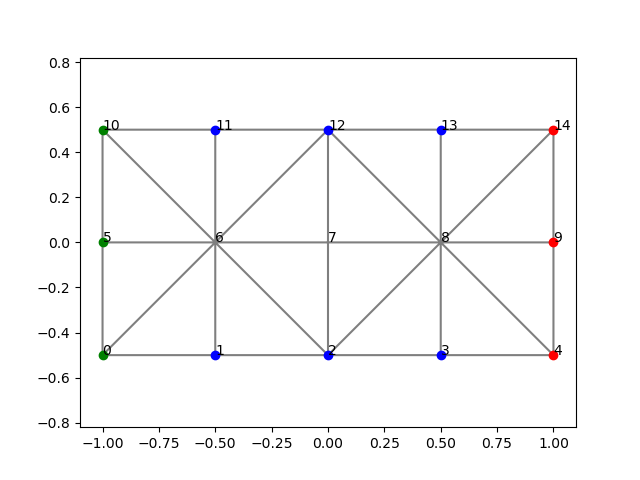

In [7]:
V, T = make_beam_mesh(2.0, 1.0, (4,2))

info = MeshInfo(V,T)

fig = plt.figure()
plt.triplot(info.V[:,0],info.V[:,1],info.T,color='k', alpha = 0.5)
for v in range(len(V)):
    plt.text(info.V[v,0],info.V[v,1], str(v))
    
    if info.is_traction_vertex(v):
        plt.plot(info.V[v,0],info.V[v,1],'ro')
        print('vertex ',v , ' is traction vertex.')
    elif info.is_static_vertex(v):
        plt.plot(info.V[v,0],info.V[v,1],'go')
        print('vertex ',v , ' is static vertex.')
    elif info.is_free_vertex(v):
        plt.plot(info.V[v,0],info.V[v,1],'bo')
        print('vertex ',v , ' is free vertex.')
        
plt.axis('equal')
plt.show()    

# Creating Vertex-centered Control Volumes
We may now use the mesh information functionality to quickly generate a simple control volume data structure.

We will take a rather brute-force approach and simply create a chunk of vertex-related information that is very specific to the simulation method we will immplement here.

We will exploit one very smart trick here which is to make a cyclic permulation a local copy of neighboring triangles such that the first index of each triangle is the vertex that they all have in common.

This is cleaver later on at run-time as we have explicit knowledge of where the two other vertices of each triangle is located in the vertex neighborhood. Further, it enable us to deduce a CCW order of triangles around a vertex. Although in this example we have little use of this knowledge.

In [8]:
def get_cyclic_permuation(v, triangle):
    i = triangle[0]
    j = triangle[1]
    k = triangle[2]
    if i==v:
        return [i, j, k]
    if j==v:
        return [j, k, i]
    if k==v:
        return [k, i, j]
    return [-1, -1, -1]


def get_ccw_triangle_order(v, T):
    for t in range(len(T)):
        T[t,:] = get_cyclic_permuation(v, T[t,:])    
    if len(T) == 1:
        ccw_order = np.array([0], dtype=np.int32).flatten()
    else:
        ccw_order = []
        next_order = -np.ones( (len(T), ), dtype=np.int32 )
        prev_order = -np.ones( (len(T), ), dtype=np.int32 )
        for s in range(len(T)):
            A = T[s,:]
            for t in range(len(T)):
                B = T[t,:]
                if A[2]==B[1]:
                    next_order[s] = t
                if A[1]==B[2]:
                    prev_order[s] = t
        if np.any(prev_order<0):
            i = np.where(prev_order<0)[0]
            while i>=0:
                ccw_order.append(i)
                i = next_order[i]
        else:
            i = 0
            ccw_order.append(i)
            i = next_order[i]
            while i>0:
                ccw_order.append(i)
                i = next_order[i]            
        ccw_order = np.array(ccw_order, dtype=np.int32).flatten()
    return ccw_order
    
    
class VertexControlVolume:

    def __init__(self, v, info):
        self.v = v
        self.c = info.V[v,:].flatten()
        self.labels = info.get_triangles_of_vertex(v)
        K = len(self.labels)        
        self.K = K
        self.boundary = info.is_boundary_vertex(v)
        
        T = info.T[self.labels,:]
        for t in range(len(T)):
            T[t,:] = get_cyclic_permuation(v, T[t,:])    
        
        self.Lij = np.zeros(( K, ), dtype=np.float64 )
        self.Lik = np.zeros(( K, ), dtype=np.float64 )
        self.Nij = np.zeros(( K, 2), dtype=np.float64 )
        self.Nik = np.zeros(( K, 2), dtype=np.float64 )
        self.Sij = np.zeros(( K, 2), dtype=np.float64 )
        self.Sik = np.zeros(( K, 2), dtype=np.float64 )
        self.D0_inv = np.zeros(( K, 2, 2), dtype=np.float64)
        self.P = np.zeros(( K, 2), dtype=np.float64 )
        self.A = np.sum(info.A[self.labels])/3.0
        for e in range(K):
            i = T[e,0]
            j = T[e,1]
            k = T[e,2]
            
            pi = info.V[i,:]
            pj = info.V[j,:]
            pk = info.V[k,:]
            
            Eij = (pj-pi)
            Lij = np.linalg.norm(Eij)
            Nij = -hat(Eij)/Lij
            
            Eik = (pk-pi)
            Lik = np.linalg.norm(Eik)
            Nik = hat(Eik)/Lik
        
            self.Lij[e] = Lij/2
            self.Lik[e] = Lik/2
            self.Nij[e,:] = Nij
            self.Nik[e,:] = Nik
            self.Sij[e,:] = Eij/2
            self.Sik[e,:] = Eik/2
            self.D0_inv[e,:,:] = np.linalg.inv(np.array([Eij, Eik]).T)
            self.P[e,:] = (pi + pj + pk)/3

Now we will do a little debug rendering to test if the information in the new control volume is created correctly.

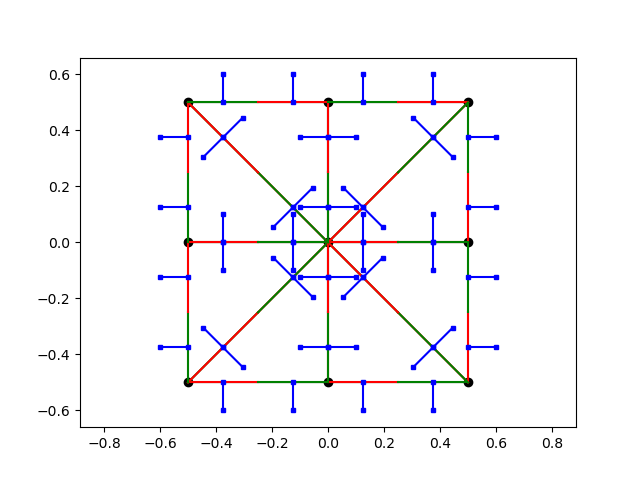

In [9]:
V, T = make_beam_mesh(1.0, 1.0, (2, 2))
info = MeshInfo(V,T)

CVs = []
for v in range(len(V)):
    cv = VertexControlVolume(v,info)
    CVs.append(cv)            

fig = plt.figure()
plt.triplot(info.V[:,0], info.V[:,1], info.T, color='k', alpha=0.2)

### Looping over vertices
for v in range(len(info.V)):
    cv = CVs[v]
    plt.plot(cv.c[0], cv.c[1], 'ko')
    
    ### Looping over neighbouring triangles
    for e in range(cv.K):
        start = cv.c
        end = cv.c + cv.Sij[e]
        plt.plot([start[0], end[0]], [start[1], end[1]], '-r')
                   
        start = cv.c
        end = cv.c + cv.Sik[e]
        plt.plot([start[0], end[0]], [start[1], end[1]], '-g')

        start = cv.c + cv.Sij[e]/2
        end = cv.c + cv.Sij[e]/2 + cv.Nij[e]*0.1
        plt.plot([start[0], end[0]], [start[1], end[1]], '-bs', ms = 3)
                   
        start = cv.c + cv.Sik[e]/2
        end = cv.c + cv.Sik[e]/2 + cv.Nik[e]*0.1
        plt.plot([start[0], end[0]], [start[1], end[1]], '-bs', ms = 3)
plt.axis('equal')
plt.show()    

Next we will render the control volume shapes so we can see how they look like. They have a very specific shape and it is easy to verify by visual inspection if they have been created correctly.

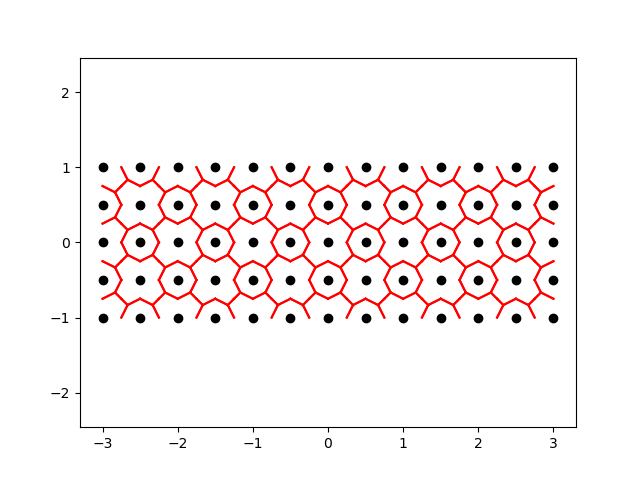

In [10]:
V, T = make_beam_mesh(6.0, 2.0, (12, 4))

info = MeshInfo(V,T)

CVs = []
for v in range(len(V)):
    cv = VertexControlVolume(v,info)
    CVs.append(cv)

fig = plt.figure()
ax = plt.subplot(111)
for v in range(len(CVs)):
    cv = CVs[v]
    plt.plot(cv.c[0],cv.c[1],'ko')
    for e in range(cv.K):
        start = cv.c + cv.Sij[e]
        end = cv.P[e]
        plt.plot([start[0], end[0]], [start[1], end[1]],'-r')
        start = cv.c + cv.Sik[e]
        end = cv.P[e]
        plt.plot([start[0], end[0]], [start[1], end[1]],'-r')
ax.axis('equal')
plt.show()

# Creating a 2D Hyperelastic Simualtor

This is your task to implement this...

In [11]:
# The areas of each control volume is stored in the VertexControlVolume class
# The material coordinate of each control volume is stored in the VertexControlVolume class
# The normal vectors of each edge of the control volume is stored in the VertexControlVolume class as cv.Nij[e] and cv.Nik[e]
# The lengths (from vertex to the midpoint) of each edge of each neighbouring triangle e of the control volume is stored in the VertexControlVolume class as cv.Lij[e] and cv.Lik[e]
# The inverse of the spatial matrix (D_0^e)^-1 for each neighbouring triangle e of a control volume is stored in the VertexControlVolume class as cv.D0_inv 
 
### Computing the deformation gradient
def compute_deformation_gradient(cv, x):
    F = np.zeros((cv.K, 2, 2), dtype=np.float64)
    for n, e in enumerate(cv.labels):
        i, j, k = get_cyclic_permuation(cv.v, T[e,:])
        pi = x[i,:]
        pj = x[j,:]
        pk = x[k,:]
        D = np.array([pj - pi, pk - pi]).T
        F[n] = D @ cv.D0_inv[n]
    return F

### Computing the strain tensor
def compute_strain(F):
    E = np.zeros((len(F), 2, 2), dtype=np.float64)
    for e in range(len(F)):
        E[e] = 0.5*(F[e].T @ F[e] - np.eye(2))
    return E

### Computing the stress tensors
def compute_2PK_stress(E, λ, μ):
    S = np.zeros((len(E), 2, 2), dtype=np.float64)
    for e in range(len(E)):
        S[e] = λ * np.trace(E[e]) * np.eye(2) + 2*μ*E[e]
    return S

def compute_1PK_stress(F, S):
    P = np.zeros((len(F), 2 ,2), dtype=np.float64)
    for e in range(len(F)):
        P[e] = F[e] @ S[e]
    return P

### Computing the elastic forces
def compute_elastic_forces(cv, info, P):
    f_ela = np.array([0,0], dtype=np.float64)
    for e in range(cv.K):
        f_ela += - (P[e] @ cv.Nij[e] * cv.Lij[e] + P[e] @ cv.Nik[e] * cv.Lik[e])
    return f_ela

### Computing the traction forces
def compute_traction_forces(cv, info, t):
    f_t = np.array([0,0], dtype=np.float64)
    for e in range(cv.K):
        f_t += cv.Lij[e] * t
    return f_t
# def compute_traction_forces(cv, info, t):
#     f_t = cv.A * t
#     return f_t

### Computing the body forces
def compute_body_forces(cv, info, b):
    f_b = cv.A * b
    return f_b

def compute_total_force(v, cv, info, x, λ, μ, t, b):
    F = compute_deformation_gradient(cv, x)
    E = compute_strain(F)
    S = compute_2PK_stress(E, λ, μ)
    P = compute_1PK_stress(F, S)
    f_ela = compute_elastic_forces(cv, info, P)
    f_b = compute_body_forces(cv, info, b)
    if info.is_traction_vertex(v):
        f_t = compute_traction_forces(cv, info, t)
    else:
        f_t = np.array([0, 0], dtype=np.float64)
    return f_ela + f_t + f_b

KeyboardInterrupt: 

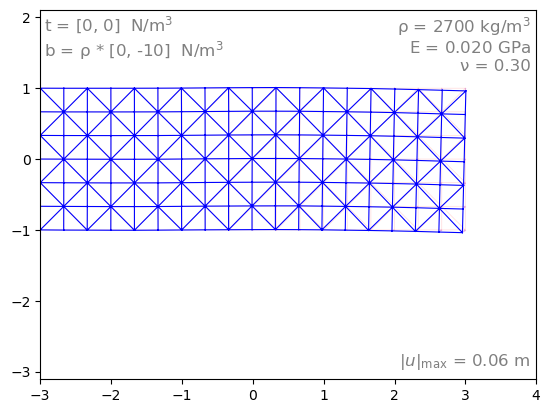

In [13]:
from IPython import display 
from time import sleep
import matplotlib.animation as animation

V, T = make_beam_mesh(6.0, 2.0, (18, 6))
info = MeshInfo(V,T)

CVs = []
CVAs = []
for v in range(len(V)):
    cv = VertexControlVolume(v, info)
    CVs.append(cv)
    CVAs.append(cv.A)

### The spatial coordinates x and the material coordinates X are initially identical.
X = V.copy()
x = V.copy()
x_old = x.copy()

Ey = 2e7 # Young modulus in Pa
nu = 0.3 # Poisson ratio
ρ = 2700 # Density of rubber in kg/m^3

λ = Ey * nu / ((1 + nu) * (1 - 2 * nu))
μ = Ey / (2 * (1 + nu))

g = 9.81 # Gravity in m/s^2
# g = 0 # Gravity in m/s^2
# load = 10000 # Load in N/m^3
load = 0 # Load in N/m^3
t = np.array([load, 0], dtype=np.float64)
b = ρ * np.array([0, -g], dtype=np.float64)

Nperm3 = '$\mathrm{N}/\mathrm{m}^3$'
kgperm3 = '$\mathrm{kg}/\mathrm{m}^3$'
GPa = '$\mathrm{GPa}$'

F_tot = np.zeros((len(V), 2), dtype=np.float64)
vel0 = np.zeros((len(V), 2), dtype=np.float64)
vel = vel0.copy()

u = np.zeros_like(x)
u_max = u.copy()

time = 0
dt = 2e-3
max_time = 10
animate = True
x = x_old + vel0 * dt + 0.5 * compute_total_force(0, CVs[0], info, x, λ, μ, t, b) * dt**2

fig, ax = plt.subplots()
xlim = [-3, 4]
ylim = [-4, 3]
def update(frame):
    global x, x_old, vel, time, u_max
    ax.clear()
    for v in range(len(V)):
        cv = CVs[v]
        F_tot[v] = compute_total_force(v, cv, info, x, λ, μ, t, b)
        
        # ### Damping
        # damping = 0.9
        # F_tot[v] -= damping * np.linalg.norm((x[v] - x_old[v])/dt)**2
        

    for v in range(len(V)):
        cv = CVs[v]

        ### Verlet integration scheme
        new_pos = 2*x[v] - x_old[v] + F_tot[v]/(cv.A * ρ) * dt**2
        x_old[v] = x[v]
        x[v] = new_pos

        if info.is_static_vertex(v):
            x[v] = X[v]
            vel[v] = np.array([0, 0])

    time += dt
    
    u = x - X
    if np.linalg.norm(u_max) < np.linalg.norm(u):
        u_max = u
    ax.triplot(X[:,0], X[:,1], T, color='red', alpha=0.15, lw=0.5)
    ax.quiver(X[:,0], X[:,1], u[:,0], u[:,1], scale=1, scale_units='xy', color='mediumorchid', width=0.003, alpha=0.5)
    ax.triplot(x[:,0], x[:,1], T, color='blue', lw=0.8)
    ax.axis('equal')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.text(xlim[0]*0.98, ylim[1]*0.68, f't = [{t[0]:.0f}, {t[1]:.0f}]  {Nperm3}\nb = ρ * [{b[0]/ρ:.0f}, {b[1]/ρ:.0f}]  {Nperm3}', fontsize=12, color='black', alpha=0.5, verticalalignment='top', horizontalalignment='left')
    ax.text(xlim[1]*0.98, ylim[1]*0.68, f'ρ = {ρ} {kgperm3}\nE = {Ey*1e-9:.3f} {GPa}\nν = {nu:.2f}', fontsize=12, color='black', alpha=0.5, verticalalignment='top', horizontalalignment='right')
    u_norm = np.linalg.norm(u, axis=1).max()
    ax.text(xlim[1]*0.98, ylim[0]*0.68, f'$|u|_\mathrm{{max}}$ = {u_norm:.2f} m', fontsize=12, color='black', alpha=0.5, verticalalignment='top', horizontalalignment='right')
    
    print(f'Time: {time:.3f} s/{max_time:.3f} s,\t({time/max_time*100:.0f} %)', end=' '*20 + '\r')

ani = animation.FuncAnimation(fig, update, frames=int(max_time/dt), repeat=False, interval = dt*1e3)

# Save the animation
ani.save('animation.mp4', writer='ffmpeg')


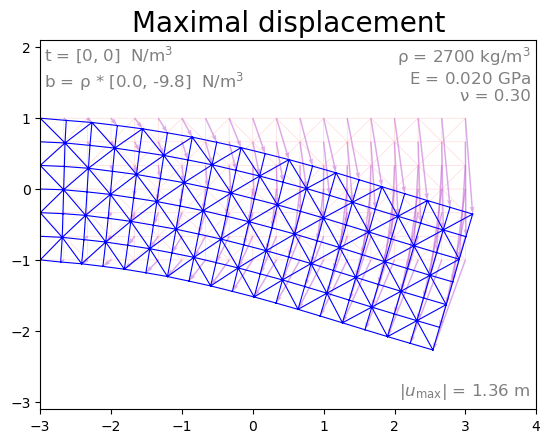

In [15]:

plt.figure()
plt.triplot(X[:,0], X[:,1], T, color='red', alpha=0.15, lw=0.5)
plt.quiver(X[:,0], X[:,1], u_max[:,0], u_max[:,1], scale=1, scale_units='xy', color='mediumorchid', width=0.003, alpha=0.5)
plt.triplot(X[:,0] + u_max[:, 0], X[:,1] + u_max[:, 1], T, color='blue', lw=0.8)
plt.axis('equal')

### Insert textbox with formatted gravity and traction vectors ###
plt.xlim(xlim)
plt.ylim(ylim)
plt.text(xlim[0]*0.98, ylim[1]*0.68, f't = [{t[0]:.0f}, {t[1]:.0f}]  {Nperm3}\nb = ρ * [{b[0]/ρ:.1f}, {b[1]/ρ:.1f}]  {Nperm3}', fontsize=12, color='black', alpha=0.5, verticalalignment='top', horizontalalignment='left')
plt.text(xlim[1]*0.98, ylim[1]*0.68, f'ρ = {ρ} {kgperm3}\nE = {Ey*1e-9:.3f} {GPa}\nν = {nu:.2f}', fontsize=12, color='black', alpha=0.5, verticalalignment='top', horizontalalignment='right')
u_maxnorm = np.linalg.norm(u_max, axis=1).max()
plt.text(xlim[1]*0.98, ylim[0]*0.68, f'$|u_\mathrm{{max}}|$ = {u_maxnorm:.2f} m', fontsize=12, color='black', alpha=0.5, verticalalignment='top', horizontalalignment='right')
plt.title('Maximal displacement', fontsize = 20)
plt.savefig('figure.png', dpi=300)